# Part 0. Baseline Model: from experiment 1

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import os
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# load data

# --- Configuration ---
TARGET_VARIABLE = 'PCT_PRICE_CHANGE_DETRENDED (%)'
RAW_TARGET_VARIABLE = 'PCT_PRICE_CHANGE (%)'
YEAR_COLUMN = 'YEAR'
ZIP_COLUMN = 'GEO_UNIQUE_ID'
TRAIN_YEAR_CUTOFF = 2020
FIRE_EXPOSED_COL = 'FIRE_EXPOSED' # Define the fire exposure column name

# --- XGBoost Tuning Parameters ---
# Define Parameter Grid for XGBoost
XGB_PARAM_GRID = {
    'n_estimators': [100, 200, 300],         # Number of trees
    'learning_rate': [0.05, 0.1, 0.2],       # Step size shrinkage
    'max_depth': [3, 5, 7],                  # Max tree depth
    'subsample': [0.7, 0.8, 0.9],            # Fraction of samples per tree
    'colsample_bytree': [0.7, 0.8, 0.9],     # Fraction of features per tree
    'gamma': [0, 0.1],                       # Minimum loss reduction for split
}
N_CV_SPLITS = 5 # Number of folds for TimeSeriesSplit

# --- Load Data ---
try:
    data = pd.read_csv("../10_Data_Clean/final_data.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: xgboost_data.csv not found. Please ensure the file is in the correct directory.")
    exit()

# --- Step 1: Detrending Target Variable ---
print("\n--- Step 1: Detrending Target Variable ---")
if YEAR_COLUMN not in data.columns or RAW_TARGET_VARIABLE not in data.columns:
     raise ValueError(f"Required columns '{YEAR_COLUMN}' or '{RAW_TARGET_VARIABLE}' not found in data.")
data[YEAR_COLUMN] = pd.to_numeric(data[YEAR_COLUMN], errors='coerce')
data = data.dropna(subset=[YEAR_COLUMN, RAW_TARGET_VARIABLE]).copy()

if not data.empty:
    trend_model = LinearRegression()
    trend_model.fit(data[[YEAR_COLUMN]], data[RAW_TARGET_VARIABLE])
    predicted_trend = trend_model.predict(data[[YEAR_COLUMN]])
    data[TARGET_VARIABLE] = data[RAW_TARGET_VARIABLE] - predicted_trend
    print(f"Target variable '{TARGET_VARIABLE}' created.")
    print(f"Target variable mean: {data[TARGET_VARIABLE].mean():.4f}, std: {data[TARGET_VARIABLE].std():.4f}")
else:
    raise ValueError("Data became empty after dropping NaNs in YEAR or RAW_TARGET_VARIABLE.")

# --- Step 2: Define Feature Sets & Imputation Rules ---
print("\n--- Step 2: Defining Feature Sets & Imputation Rules ---")

# Core Baseline Features
baseline_features = [
    'Median_Household_Income', 'Total_Population', 'Avg_Household_Size',
    'Gini_Index', 'Employment_Rate', 'Below_Poverty_Rate',
    'Rate_College_or_Higher', 'Black_Portion', 'White_Portion',
    'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion',
    # Lagged Price Features
    'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1', 'PRICE_CHANGE_DIFF',
    'ROLLING_1yr_PRICE_CHANGE', 'ROLLING_2yr_PRICE_CHANGE_STD'
    # Avoid interaction terms involving FIRE here
]

# Specific Wildfire Features (excluding interactions for now)
wildfire_features_only = [
    'NUM_FIRES', 'TOTAL_AREA_BURNED_IN_M2', 'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_TRACT_BURNED', 'ANY_MAJOR_FIRE', 'FIRE_EXPOSED',
    'PREV_MAX_PCT_TRACT_BURNED', 'FIRE_LAST_YEAR', 'FIRE_SHOCK',
    'YEARS_SINCE_LAST_FIRE', 'CUMULATIVE_AREA_BURNED_LAST_2YRS',
]

# Interaction Terms
interaction_features = [
    'FIRE_EXPOSED_x_PRICE_CHANGE_LAG1',
    'MAX_PCT_TRACT_BURNED_x_ROLLING_1yr_PRICE_CHANGE',
    'FIRE_EXPOSED_x_Median_Household_Income',
    'FIRE_EXPOSED_x_Below_Poverty_Rate'
]

# One-hot encode ‘neighbor_category’
neighbor_dummies = pd.get_dummies(
    data['neighbor_category'],
    prefix='neighbor'
)
data = pd.concat([data, neighbor_dummies], axis=1)

# Add the new columns into your feature list
wildfire_features_only += neighbor_dummies.columns.tolist()

# Filter features to only those present in the data
baseline_features = [f for f in baseline_features if f in data.columns]
wildfire_features_only = [f for f in wildfire_features_only if f in data.columns]
interaction_features = [f for f in interaction_features if f in data.columns]

# --- Define Imputation Rules ---
# 1. Features where NaN means zero activity (primarily fire counts/extent)
zero_fill_fire_metrics = [
    'NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE',
    'PREV_MAX_PCT_ZIP_BURNED', 'FIRE_LAST_YEAR', 'FIRE_SHOCK',
    'CUMULATIVE_ACRES_BURNED_LAST_3YRS',
    # FIRE_EXPOSED is binary, NaN is usually invalid here, but treat as 0 if present
    FIRE_EXPOSED_COL
]
zero_fill_fire_metrics = [f for f in zero_fill_fire_metrics if f in data.columns and f in wildfire_features_only]

# 2. Interaction term definitions (map interaction term to its components)
# Format: {'INTERACTION_TERM': ('FIRE_RELATED_VAR', 'OTHER_VAR')}
interaction_pairs = {
    'FIRE_EXPOSED_x_PRICE_CHANGE_LAG1': (FIRE_EXPOSED_COL, 'PRICE_CHANGE_LAG1'),
    'FIRE_EXPOSED_x_Median_Household_Income': (FIRE_EXPOSED_COL, 'Median_Household_Income'),
    'MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE': ('MAX_PCT_ZIP_BURNED', 'ROLLING_1yr_PRICE_CHANGE'),
    'FIRE_EXPOSED_x_Below_Poverty_Rate': (FIRE_EXPOSED_COL, 'Below_Poverty_Rate')
}
# Filter pairs to only those where term and components exist in the data
interaction_pairs = {
    k: v for k, v in interaction_pairs.items()
    if k in interaction_features and v[0] in data.columns and v[1] in data.columns
}

# 3. Features for Grouped Median Imputation (based on FIRE_EXPOSED status)
grouped_median_impute_cols = [
    'Median_Household_Income', 'Employment_Rate',
    'ROLLING_1yr_PRICE_CHANGE', 'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1', 'PRICE_CHANGE_DIFF',
    'YEARS_SINCE_LAST_FIRE', 'Below_Poverty_Rate'
]
grouped_median_impute_cols = [f for f in grouped_median_impute_cols if f in data.columns]
grouped_median_impute_cols = list(set(grouped_median_impute_cols) - set(zero_fill_fire_metrics)) # Avoid double handling

# --- Combine Feature Sets ---
# Baseline model uses only baseline features
# Wildfire model uses baseline + wildfire-only + interactions
all_features = sorted(list(set(baseline_features + wildfire_features_only + interaction_features)))

# Ensure FIRE_EXPOSED_COL is in the feature lists if needed for imputation/modeling
if FIRE_EXPOSED_COL not in baseline_features:
    print(f"Note: '{FIRE_EXPOSED_COL}' not in baseline_features list, will be added temporarily if needed for grouped imputation.")
if FIRE_EXPOSED_COL not in all_features and FIRE_EXPOSED_COL in data.columns:
    all_features.append(FIRE_EXPOSED_COL)
    all_features = sorted(list(set(all_features)))

# Verify no target/future leakage
leaky_features = ['PRICE', 'NEXT_YEAR_PRICE', 'PRICE_CHANGE', RAW_TARGET_VARIABLE, TARGET_VARIABLE]
for f in leaky_features:
    if f in all_features:
        print(f"CRITICAL WARNING: Leaky feature '{f}' found in 'all_features'. Removing.")
        all_features.remove(f)
    if f in baseline_features:
        print(f"CRITICAL WARNING: Leaky feature '{f}' found in 'baseline_features'. Removing.")
        baseline_features.remove(f)

print(f"\nUsing Baseline Features ({len(baseline_features)}): {baseline_features}")
print(f"Using Wildfire Features Only ({len(wildfire_features_only)}): {wildfire_features_only}")
print(f"Using Interaction Features ({len(interaction_features)}): {interaction_features}")
print(f"Using All Features for WF model ({len(all_features)}): {all_features}")
print(f"\nImputation Rules:")
print(f" Zero-fill NaNs for ({len(zero_fill_fire_metrics)}): {zero_fill_fire_metrics}")
print(f" Grouped median impute for ({len(grouped_median_impute_cols)}): {grouped_median_impute_cols}")
print(f" Interaction handling for ({len(interaction_pairs)}): {list(interaction_pairs.keys())}")

# --- Step 3: Sort Data and Temporal Split ---
print(f"\n--- Step 3: Splitting Data: Train <= {TRAIN_YEAR_CUTOFF}, Test > {TRAIN_YEAR_CUTOFF} ---")
data = data.sort_values(by=[YEAR_COLUMN, ZIP_COLUMN]).reset_index(drop=True)

train_data = data[data[YEAR_COLUMN] <= TRAIN_YEAR_CUTOFF].copy()
test_data = data[data[YEAR_COLUMN] > TRAIN_YEAR_CUTOFF].copy()

if train_data.empty or test_data.empty:
    raise ValueError(f"Train or test split resulted in empty DataFrame. Check TRAIN_YEAR_CUTOFF ({TRAIN_YEAR_CUTOFF}).")
if not train_data.empty and not test_data.empty and train_data[YEAR_COLUMN].max() >= test_data[YEAR_COLUMN].min():
     print(f"Warning: Potential overlap/edge case in year split. Max train year: {train_data[YEAR_COLUMN].max()}, Min test year: {test_data[YEAR_COLUMN].min()}")

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape:  {test_data.shape}")

y_train = train_data[TARGET_VARIABLE]
y_test = test_data[TARGET_VARIABLE]

# Get Raw Feature Sets for Preprocessing
X_train_base_raw = train_data[baseline_features].copy()
X_test_base_raw = test_data[baseline_features].copy()

X_train_wf_raw = train_data[all_features].copy()
X_test_wf_raw = test_data[all_features].copy()

# --- Add FIRE_EXPOSED_COL temporarily if needed for grouped imputation ---
# For baseline features
if FIRE_EXPOSED_COL not in X_train_base_raw.columns and FIRE_EXPOSED_COL in train_data.columns:
    X_train_base_raw[FIRE_EXPOSED_COL] = train_data[FIRE_EXPOSED_COL]
    X_test_base_raw[FIRE_EXPOSED_COL] = test_data[FIRE_EXPOSED_COL]
    print(f"Temporarily added '{FIRE_EXPOSED_COL}' to baseline features for imputation.")
# For wildfire features (should already be there if defined correctly)
if FIRE_EXPOSED_COL not in X_train_wf_raw.columns and FIRE_EXPOSED_COL in train_data.columns:
     X_train_wf_raw[FIRE_EXPOSED_COL] = train_data[FIRE_EXPOSED_COL]
     X_test_wf_raw[FIRE_EXPOSED_COL] = test_data[FIRE_EXPOSED_COL]
     print(f"Added '{FIRE_EXPOSED_COL}' to wildfire features (was missing).")
     
# --- Step 4: Preprocessing Pipeline (Grouped Impute THEN Scale) ---
print("\n--- Step 4: Preprocessing Pipeline (Grouped Impute THEN Scale) ---")

def preprocess_features_grouped_impute(X_train, X_test,
                                      fire_exposed_col='FIRE_EXPOSED',
                                      zero_fill_metrics=None,
                                      grouped_median_cols=None,
                                      interaction_pairs_dict=None):
    """
    Applies grouped imputation based on FIRE_EXPOSED status, then scales.
    Fits imputation stats and scaler ONLY on training data.
    """
    print(f"--- Preprocessing {len(X_train.columns)} features ---")
    X_train_proc = X_train.copy()
    X_test_proc = X_test.copy()
    feature_names = X_train.columns.tolist()
    imputation_values_train = {}

    if fire_exposed_col not in X_train.columns or fire_exposed_col not in X_test.columns:
         raise ValueError(f"'{fire_exposed_col}' column missing from input DataFrames for preprocessing.")

    # --- Imputation Strategy ---

    # 1. Handle explicit zero-fill metrics first
    if zero_fill_metrics:
        actual_zero_fill = [col for col in zero_fill_metrics if col in feature_names]
        if actual_zero_fill:
            print(f" 1. Zero-filling NaNs for: {actual_zero_fill}")
            for col in actual_zero_fill:
                X_train_proc[col] = X_train_proc[col].fillna(0)
                X_test_proc[col] = X_test_proc[col].fillna(0)
        else:
            print(" 1. No specified zero-fill metrics found in columns.")

    # 2. Handle Interaction Terms
    if interaction_pairs_dict:
        print(" 2. Handling interaction terms...")
        for interaction_term, components in interaction_pairs_dict.items():
            if interaction_term not in feature_names: continue

            fire_comp, _ = components # ('FIRE_RELATED_VAR', 'OTHER_VAR')

            # Need fire component values (use 0 if NaN after potential zero-fill)
            fire_component_values_train = X_train_proc[fire_comp].fillna(0)
            fire_component_values_test = X_test_proc[fire_comp].fillna(0)

            # Condition where interaction should be 0 (fire component is 0)
            zero_condition_train = (fire_component_values_train == 0)
            zero_condition_test = (fire_component_values_test == 0)

            # Impute with 0 where condition is met AND interaction term is NaN
            train_null_mask = X_train_proc[interaction_term].isnull()
            test_null_mask = X_test_proc[interaction_term].isnull()
            X_train_proc.loc[zero_condition_train & train_null_mask, interaction_term] = 0
            X_test_proc.loc[zero_condition_test & test_null_mask, interaction_term] = 0

            # For remaining NaNs (where fire comp > 0), use grouped median from TRAIN
            if X_train_proc.loc[~zero_condition_train, interaction_term].isnull().any():
                 median_interaction_fire = X_train_proc.loc[~zero_condition_train, interaction_term].median()
                 imputation_values_train[interaction_term + '_fire'] = median_interaction_fire

                 # Apply to remaining NaNs in both train and test
                 X_train_proc.loc[~zero_condition_train & X_train_proc[interaction_term].isnull(), interaction_term] = median_interaction_fire
                 X_test_proc.loc[~zero_condition_test & X_test_proc[interaction_term].isnull(), interaction_term] = median_interaction_fire
            else:
                 # Store NaN or 0 if no valid median could be calculated (e.g., all NaNs or no fire>0 cases)
                 imputation_values_train[interaction_term + '_fire'] = X_train_proc.loc[~zero_condition_train, interaction_term].median() # Recalc to store NaN if needed
                 # Apply this value (could be NaN) - will be handled by fallback imputer if necessary
                 X_test_proc.loc[~zero_condition_test & X_test_proc[interaction_term].isnull(), interaction_term] = imputation_values_train[interaction_term + '_fire']


    # 3. Grouped Median Imputation for other columns
    if grouped_median_cols:
        print(f" 3. Applying grouped median imputation for: {grouped_median_cols}")
        # Get indices for fire/no-fire groups IN TRAINING DATA
        train_fire_idx = X_train_proc[fire_exposed_col] == 1
        train_no_fire_idx = X_train_proc[fire_exposed_col] == 0
        # Get indices for TEST data groups
        test_fire_idx = X_test_proc[fire_exposed_col] == 1
        test_no_fire_idx = X_test_proc[fire_exposed_col] == 0

        for col in grouped_median_cols:
            if col not in feature_names: continue
            if X_train_proc[col].isnull().any() or X_test_proc[col].isnull().any(): # Check if imputation needed
                # Calculate medians ONLY from Training data groups
                median_no_fire = X_train_proc.loc[train_no_fire_idx, col].median()
                median_fire = X_train_proc.loc[train_fire_idx, col].median()

                # Store medians
                imputation_values_train[col + '_no_fire'] = median_no_fire
                imputation_values_train[col + '_fire'] = median_fire

                # Apply to TRAIN set
                X_train_proc.loc[train_no_fire_idx, col] = X_train_proc.loc[train_no_fire_idx, col].fillna(median_no_fire)
                X_train_proc.loc[train_fire_idx, col] = X_train_proc.loc[train_fire_idx, col].fillna(median_fire)

                # Apply to TEST set (using medians learned from TRAIN)
                X_test_proc.loc[test_no_fire_idx, col] = X_test_proc.loc[test_no_fire_idx, col].fillna(median_no_fire)
                X_test_proc.loc[test_fire_idx, col] = X_test_proc.loc[test_fire_idx, col].fillna(median_fire)

    # 4. Final check for any remaining NaNs (use global median as fallback)
    fallback_imputer = SimpleImputer(strategy='median')
    try:
        # Check NaNs *after* all specific imputations
        if X_train_proc.isnull().values.any():
            nan_cols_train = X_train_proc.columns[X_train_proc.isnull().any()].tolist()
            print(f" 4. WARNING: NaNs still present after specific imputations in TRAIN columns: {nan_cols_train}. Applying global median fallback...")
            X_train_proc[nan_cols_train] = fallback_imputer.fit_transform(X_train_proc[nan_cols_train])
            # Check and apply to test set for same columns if needed
            nan_cols_test = X_test_proc.columns[X_test_proc.isnull().any()].tolist()
            cols_to_transform_test = [col for col in nan_cols_train if col in nan_cols_test]
            if cols_to_transform_test:
                 print(f"    Applying fallback imputation to TEST columns: {cols_to_transform_test}")
                 X_test_proc[cols_to_transform_test] = fallback_imputer.transform(X_test_proc[cols_to_transform_test])
        else:
             print(" 4. No NaNs found after specific imputations. Skipping fallback.")
             # Fit the imputer anyway in case test set has NaNs in columns train didn't
             fallback_imputer.fit(X_train_proc)


        # Final check on TEST set for any NaNs missed (e.g., column had no NaNs in train but does in test)
        if X_test_proc.isnull().values.any():
             nan_cols_test_final = X_test_proc.columns[X_test_proc.isnull().any()].tolist()
             print(f"    WARNING: NaNs found in TEST columns: {nan_cols_test_final} possibly missed by train fit. Applying fallback transform...")
             # Use the imputer fitted on train data
             X_test_proc[nan_cols_test_final] = fallback_imputer.transform(X_test_proc[nan_cols_test_final])


    except ValueError as e:
         print(f"ERROR during fallback imputation: {e}. NaNs might remain.")


    # --- Scaling Step ---
    print(" 5. Applying StandardScaler...")
    scaler = StandardScaler()
    # Ensure column order is the same before scaling
    X_train_proc = X_train_proc[feature_names]
    X_test_proc = X_test_proc[feature_names]

    X_train_scaled = scaler.fit_transform(X_train_proc)
    X_test_scaled = scaler.transform(X_test_proc)

    # Convert back to DataFrame
    X_train_processed = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
    X_test_processed = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

    print("--- Preprocessing Complete ---")
    return X_train_processed, X_test_processed, scaler, imputation_values_train # Return learned values


# --- Apply Preprocessing ---

print("\nProcessing Baseline Features (Grouped Impute THEN Scale)...")
X_train_base_processed, X_test_base_processed, scaler_base, impute_vals_base = preprocess_features_grouped_impute(
    X_train_base_raw, X_test_base_raw,
    fire_exposed_col=FIRE_EXPOSED_COL,
    zero_fill_metrics=[], # No specific fire metrics in baseline usually
    grouped_median_cols= [c for c in grouped_median_impute_cols if c in baseline_features], # Only impute baseline cols
    interaction_pairs_dict={} # No interactions in baseline
)
print("Baseline features processed.")

# Remove the temporarily added FIRE_EXPOSED_COL from baseline processed sets if it wasn't originally intended
if FIRE_EXPOSED_COL in X_train_base_processed.columns and FIRE_EXPOSED_COL not in baseline_features:
    X_train_base_processed = X_train_base_processed.drop(columns=[FIRE_EXPOSED_COL])
    X_test_base_processed = X_test_base_processed.drop(columns=[FIRE_EXPOSED_COL])
    print(f"Removed temporary '{FIRE_EXPOSED_COL}' from processed baseline features.")


print("\nProcessing All Features (Wildfire Included - Grouped Impute THEN Scale)...")
X_train_wf_processed, X_test_wf_processed, scaler_wf, impute_vals_wf = preprocess_features_grouped_impute(
    X_train_wf_raw, X_test_wf_raw,
    fire_exposed_col=FIRE_EXPOSED_COL,
    zero_fill_metrics=zero_fill_fire_metrics,
    grouped_median_cols=grouped_median_impute_cols,
    interaction_pairs_dict=interaction_pairs
)
print("All features (including wildfire) processed.")

Data loaded successfully.

--- Step 1: Detrending Target Variable ---
Target variable 'PCT_PRICE_CHANGE_DETRENDED (%)' created.
Target variable mean: 0.0000, std: 10.5283

--- Step 2: Defining Feature Sets & Imputation Rules ---
Note: 'FIRE_EXPOSED' not in baseline_features list, will be added temporarily if needed for grouped imputation.

Using Baseline Features (16): ['Median_Household_Income', 'Total_Population', 'Avg_Household_Size', 'Gini_Index', 'Employment_Rate', 'Below_Poverty_Rate', 'Rate_College_or_Higher', 'Black_Portion', 'White_Portion', 'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion', 'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1', 'PRICE_CHANGE_DIFF', 'ROLLING_1yr_PRICE_CHANGE', 'ROLLING_2yr_PRICE_CHANGE_STD']
Using Wildfire Features Only (15): ['NUM_FIRES', 'TOTAL_AREA_BURNED_IN_M2', 'AVG_FIRE_DURATION_DAYS', 'MAX_PCT_TRACT_BURNED', 'ANY_MAJOR_FIRE', 'FIRE_EXPOSED', 'PREV_MAX_PCT_TRACT_BURNED', 'FIRE_LAST_YEAR', 'FIRE_SHOCK', 'YEARS_SINCE_LAST_FIRE', 'CUMULATIVE_AR

/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


 4. WARNING: NaNs still present after specific imputations in TRAIN columns: ['MAX_PCT_TRACT_BURNED_x_ROLLING_1yr_PRICE_CHANGE', 'YEARS_SINCE_LAST_FIRE']. Applying global median fallback...
    Applying fallback imputation to TEST columns: ['MAX_PCT_TRACT_BURNED_x_ROLLING_1yr_PRICE_CHANGE', 'YEARS_SINCE_LAST_FIRE']
 5. Applying StandardScaler...
--- Preprocessing Complete ---
All features (including wildfire) processed.


In [3]:
# dataset create
print("X_train shape:", X_train_wf_processed.shape) 
print("y_train shape:", y_train.shape)       

print("X_test shape:", X_test_wf_processed.shape)        
print("y_test shape:", y_test.shape)  

X_train shape: (60185, 35)
y_train shape: (60185,)
X_test shape: (13238, 35)
y_test shape: (13238,)


In [4]:
# Call Xgboost model with wildfire features
loaded_model_ubj = XGBRegressor()
loaded_model_ubj.load_model('../20_Model/xgboost_wf_model.ubj') # or 'xgboost_base_model.ubj'

# y_pred_model_ubj = loaded_model_ubj.predict(X_train_wf_processed)


### Based on Experiment 1, we pick XGBoost with Wildfire which has the best prediction performance.
### loaded_model_ubj & its Prediction y_pred_model_ubj
### Target Varialbe: PCT_PRICE_CHANGE_DETRENDED (%)

In [5]:
#Use the best model xgb_wf to make predictions on the test set (with wildfire features)
y_pred_model_ubj = loaded_model_ubj.predict(X_test_wf_processed)
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_model_ubj)):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_model_ubj):.4f}")


RMSE: 3.2988
R2 Score: 0.8961


# (Part 1) Performance comparison of Drop Group vs Increase Group

## 1. EDA
### 1.1 Explore Data：All data, do not filter fire

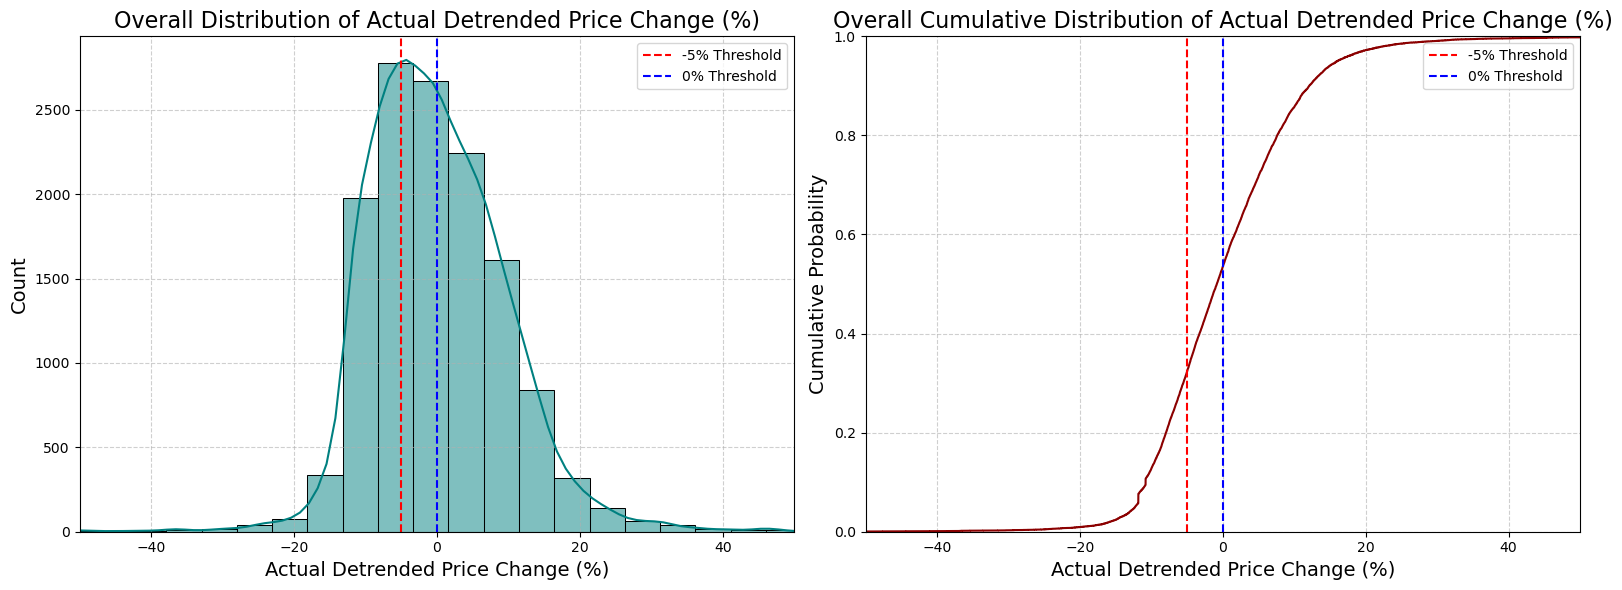

In [6]:
TARGET_VARIABLE = y_test

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(TARGET_VARIABLE, bins=50, kde=True, color='teal', ax=axes[0])
axes[0].axvline(x=-5, color='red', linestyle='--', label='-5% Threshold')
axes[0].axvline(x=0, color='blue', linestyle='--', label='0% Threshold')
axes[0].set_xlim(-50, 50)
axes[0].set_title('Overall Distribution of Actual Detrended Price Change (%)', fontsize=16)
axes[0].set_xlabel('Actual Detrended Price Change (%)', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

sns.ecdfplot(TARGET_VARIABLE, color='darkred', ax=axes[1])
axes[1].axvline(x=-5, color='red', linestyle='--', label='-5% Threshold')
axes[1].axvline(x=0, color='blue', linestyle='--', label='0% Threshold')
axes[1].set_xlim(-50, 50)
axes[1].set_title('Overall Cumulative Distribution of Actual Detrended Price Change (%)', fontsize=16)
axes[1].set_xlabel('Actual Detrended Price Change (%)', fontsize=14)
axes[1].set_ylabel('Cumulative Probability', fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### 1.2 Explore Data：All data, filter fire

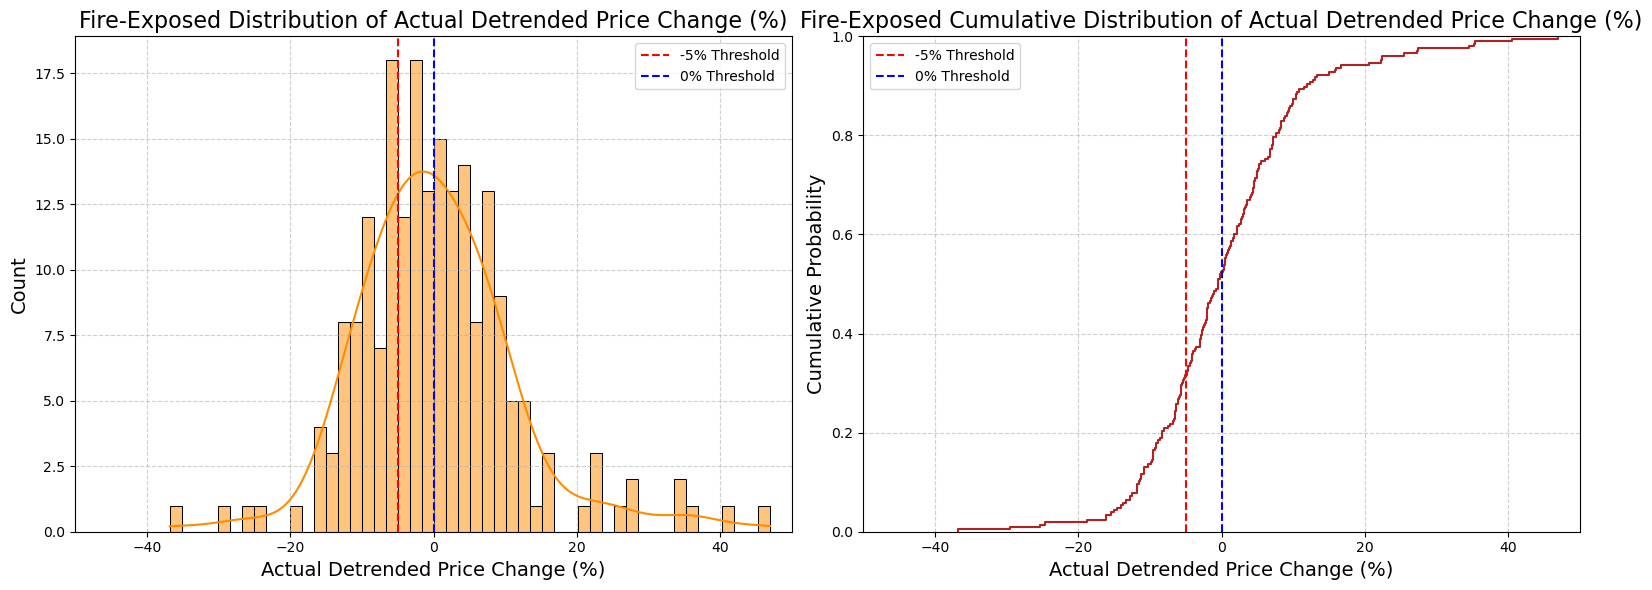

In [7]:
# Use X_test_wf_raw (raw data) to get FIRE_EXPOSED mask
fire_exposed_idx = X_test_wf_raw['FIRE_EXPOSED'] == 1

# Then use this mask in y_test to get the corresponding target value
TARGET_VARIABLE_FIRE = y_test[fire_exposed_idx]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(TARGET_VARIABLE_FIRE, bins=50, kde=True, color='darkorange', ax=axes[0])
axes[0].axvline(x=-5, color='red', linestyle='--', label='-5% Threshold')
axes[0].axvline(x=0, color='blue', linestyle='--', label='0% Threshold')
axes[0].set_xlim(-50, 50)
axes[0].set_title('Fire-Exposed Distribution of Actual Detrended Price Change (%)', fontsize=16)
axes[0].set_xlabel('Actual Detrended Price Change (%)', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

sns.ecdfplot(TARGET_VARIABLE_FIRE, color='firebrick', ax=axes[1])
axes[1].axvline(x=-5, color='red', linestyle='--', label='-5% Threshold')
axes[1].axvline(x=0, color='blue', linestyle='--', label='0% Threshold')
axes[1].set_xlim(-50, 50)
axes[1].set_title('Fire-Exposed Cumulative Distribution of Actual Detrended Price Change (%)', fontsize=16)
axes[1].set_xlabel('Actual Detrended Price Change (%)', fontsize=14)
axes[1].set_ylabel('Cumulative Probability', fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### 1.3. [Increase/Decrease] [Severe Drop Ratio] (Total Data vs Fire-Exposed) Quantity Comparison Table

In [8]:
#Overall
total_samples = len(y_test)
severe_samples = (y_test <= -5).sum()
small_moderate_samples = ((y_test > -5) & (y_test <= 0)).sum()
increase_samples = (y_test > 0).sum()

print("=== Overall Test Set ===")
print(f"Total samples: {total_samples}")
print(f"Severe Drop (≤ -5%): {severe_samples} ({severe_samples/total_samples*100:.2f}%)")
print(f"Small/Moderate Drop (-5% to 0%): {small_moderate_samples} ({small_moderate_samples/total_samples*100:.2f}%)")
print(f"Increase (> 0%): {increase_samples} ({increase_samples/total_samples*100:.2f}%)")

# Fire-Exposed
fire_exposed_idx = X_test_wf_raw['FIRE_EXPOSED'] == 1
y_test_fire = y_test[fire_exposed_idx]

fire_total = len(y_test_fire)
fire_severe = (y_test_fire <= -5).sum()
fire_small_moderate = ((y_test_fire > -5) & (y_test_fire <= 0)).sum()
fire_increase = (y_test_fire > 0).sum()

print("\n=== Fire-Exposed Test Set ===")
print(f"Total samples: {fire_total}")
print(f"Severe Drop (≤ -5%): {fire_severe} ({fire_severe/fire_total*100:.2f}%)")
print(f"Small/Moderate Drop (-5% to 0%): {fire_small_moderate} ({fire_small_moderate/fire_total*100:.2f}%)")
print(f"Increase (> 0%): {fire_increase} ({fire_increase/fire_total*100:.2f}%)")


=== Overall Test Set ===
Total samples: 13238
Severe Drop (≤ -5%): 4277 (32.31%)
Small/Moderate Drop (-5% to 0%): 2808 (21.21%)
Increase (> 0%): 6153 (46.48%)

=== Fire-Exposed Test Set ===
Total samples: 206
Severe Drop (≤ -5%): 65 (31.55%)
Small/Moderate Drop (-5% to 0%): 43 (20.87%)
Increase (> 0%): 98 (47.57%)


Across the overall test set, approximately 32% of properties experienced a severe price drop (≤ -5%). In fire-exposed areas, a similar proportion (31.55%) experienced severe drops. Additionally, the distribution of small/moderate drops and price increases in fire-exposed areas closely mirrors that of the overall dataset.

This suggests that fire-exposed areas do not exhibit a statistically distinct price change pattern from the overall dataset, at least in terms of drop/increase composition. Therefore, subsequent classification models can be trained and evaluated on the full dataset, without restricting the sample to fire-exposed regions.

## 2. Why test model ​between Drop (y < 0) and Increase (y ≥ 0)

### 2.1 The difference in the distribution of regression target values ​​between Drop (y < 0) and Increase (y ≥ 0)

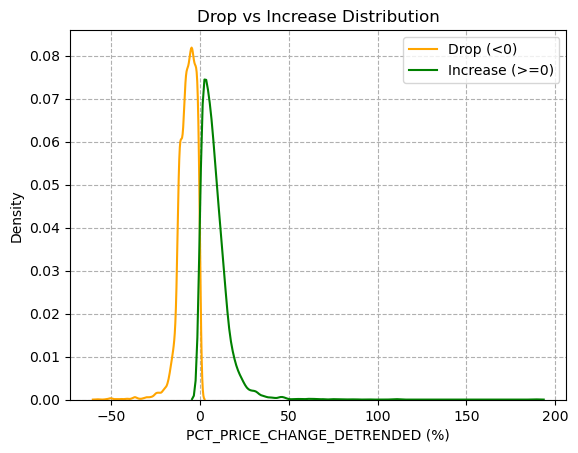

In [9]:
is_drop = y_test < 0
drop = y_test[is_drop]
increase = y_test[~is_drop]

sns.kdeplot(drop, label='Drop (<0)', color='orange')
sns.kdeplot(increase, label='Increase (>=0)', color='green')
plt.title('Drop vs Increase Distribution')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()


As shown in the KDE plot of actual detrended price changes, the distribution of properties that experienced a price drop (i.e., values < 0) is substantially different from those that experienced an increase (values ≥ 0). Drop cases are concentrated around modest negative changes, while increase cases are more dispersed and exhibit a heavier right tail. This distinction justifies treating drop versus increase as a meaningful classification target, even though the model is trained in a regression framework.



### 2.2 Comparison: True (y_test) vs Predicted (y_pred_model_ubj) 


In [10]:
# 1. Define a function to categorize the distribution into three groups
def categorize_distribution(y_values, name="Dataset"):
    total = len(y_values)
    severe = (y_values <= -5).sum()
    small_moderate = ((y_values > -5) & (y_values <= 0)).sum()
    increase = (y_values > 0).sum()
    return {
        "Name": name,
        "Total": total,
        "Severe Drop (≤ -5%)": f"{severe} ({severe/total*100:.2f}%)",
        "Small/Moderate Drop (-5% to 0%)": f"{small_moderate} ({small_moderate/total*100:.2f}%)",
        "Increase (>0%)": f"{increase} ({increase/total*100:.2f}%)"
    }

# 2. Categorize the overall test set (actual and predicted)
overall_actual = categorize_distribution(y_test, "Overall Actual")
overall_predicted = categorize_distribution(y_pred_model_ubj, "Overall Predicted")

# # 3. Categorize the fire-exposed subset (actual and predicted)
# fire_exposed_idx = X_test_wf_processed['FIRE_EXPOSED'] == 1
# y_test_fire = y_test[fire_exposed_idx]
# y_pred_fire = y_pred_model_ubj[fire_exposed_idx]

# fire_actual = categorize_distribution(y_test_fire, "Fire-Exposed Actual")
# fire_predicted = categorize_distribution(y_pred_fire, "Fire-Exposed Predicted")

# 4. Combine all results into a summary table
import pandas as pd

distribution_comparison = pd.DataFrame([
    overall_actual,
    overall_predicted,
])

print(distribution_comparison)

                Name  Total Severe Drop (≤ -5%)  \
0     Overall Actual  13238       4277 (32.31%)   
1  Overall Predicted  13238       2734 (20.65%)   

  Small/Moderate Drop (-5% to 0%) Increase (>0%)  
0                   2808 (21.21%)  6153 (46.48%)  
1                   3071 (23.20%)  7433 (56.15%)  


The distribution comparison reveals that the model tends to systematically underestimate severe price declines while maintaining reasonable accuracy in predicting price increases. This discrepancy highlights the necessity of separately evaluating the model’s performance for properties expected to experience a price drop versus an increase.  
In particular, recall and precision metrics should be examined for the drop category to ensure that high-risk declines are adequately captured.  


## 3. Train Model to different Level

### 3.1 Performance comparison of Drop Group vs Increase Group

In [11]:
# Set the threshold for severe decline
severe_threshold = 0

# Group by real y_test
severe_idx = (y_test <=  severe_threshold)
small_moderate_idx = (y_test > severe_threshold) 

# Extract test set features and targets for each group
X_test_severe = X_test_wf_processed[severe_idx]
y_test_severe = y_test[severe_idx]

X_test_small_moderate = X_test_wf_processed[small_moderate_idx]
y_test_small_moderate = y_test[small_moderate_idx]

# Use the existing model xgb_wf to predict on each group
y_pred_severe = loaded_model_ubj.predict(X_test_severe)
y_pred_small_moderate = loaded_model_ubj.predict(X_test_small_moderate)

# Evaluate performance separately

print("===  Drop Group ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_severe, y_pred_severe)):.4f}")
print(f"R2 Score: {r2_score(y_test_severe, y_pred_severe):.4f}")

print("\n=== Increase Group ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_small_moderate, y_pred_small_moderate)):.4f}")
print(f"R2 Score: {r2_score(y_test_small_moderate, y_pred_small_moderate):.4f}")

print("\n=== Overall Test Set ===")
y_pred_all = loaded_model_ubj.predict(X_test_wf_processed)  
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_all)):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred_all):.4f}")

===  Drop Group ===
RMSE: 3.2253
R2 Score: 0.6075

=== Increase Group ===
RMSE: 3.3815
R2 Score: 0.8367

=== Overall Test Set ===
RMSE: 3.2988
R2 Score: 0.8961


| Metric Category | RMSE    | R²     |
|-----------------|---------|--------|
| **Overall**     | 3.2988  | 0.8961 |
| **Drop** (y $<$ 0)| 3.2253  | 0.6075 |
| **Increase** (y $\geq$ 0) | 3.3815 | 0.8367 |

The current model significantly underestimates severe price declines and performs notably worse on properties experiencing price drops (R² = 0.61) compared to price increases (R² = 0.84).
This suggests that designing a specialized model or adjustment focusing on predicting downward price movements could meaningfully improve overall predictive performance.



Based on the experimental results, the current model underperforms significantly in predicting properties with price declines (y <= 0), achieving an R² of only 0.6075 compared to 0.8367 for price increases.  
So, it is reasonable and justified to propose designing a specialized model or adjustment specifically targeting the price drop region (y= 0) to improve predictive performance in critical cases.

### 3.3 Check if Imbalance of Training Dataset


In [12]:
total_train_samples = len(y_train)
drop_train_samples = (y_train < 0).sum()
increase_train_samples = ((y_train >= 0)).sum()

print("=== Overall Train Set ===")
print(f"Total samples: {total_train_samples}")
print(f"Drop (≤ 0%): {drop_train_samples} ({drop_train_samples/total_train_samples*100:.2f}%)")
print(f"Increase (> 0%): {increase_train_samples} ({increase_train_samples/total_train_samples*100:.2f}%)")


=== Overall Train Set ===
Total samples: 60185
Drop (≤ 0%): 34639 (57.55%)
Increase (> 0%): 25546 (42.45%)


Even if the sample distribution is relatively balanced, you may still encounter the situation where the model predicts poorly for drop samples. The reasons may be:

1. The characteristics of drop samples are more complex/heterogeneous
Samples with y < 0 may contain a variety of different mechanisms (such as fire shock, economic depression, etc.), which are difficult to fit with a unified model.
2. The loss function is not sensitive enough to "missed drops"
The default RMSE or MAE "treats" each type of error "averagely" and does not prioritize learning samples with severe drops.
3. The model tends to predict the central area
The model learns to "minimize the overall error", which easily compresses the predicted value close to the median, sacrificing the prediction quality of extreme drops.

# Part 2: Two-model approach

**Justification for Choosing the Two-Model Approach**    
Although the training set is relatively balanced in terms of sample counts across price drops and increases, our analysis indicates that the model performs significantly worse on drop cases. This suggests that sample complexity, not just quantity, contributes to prediction difficulty.

Rather than attempting to force a single regression model to learn both behaviors through reweighting, we adopt a two-stage modeling approach that offers greater interpretability and targeted performance:

Stage 1: Classification  
A binary classifier is trained to predict whether a given case will result in a price drop or increase.

Stage 2: Conditional Regression  
Based on the predicted class:

For increases, we use the baseline model, which already performs well.

For drops, we train a dedicated regression model optimized for this subgroup to better capture the variation and risk factors underlying price declines.

This architecture not only addresses the observed performance asymmetry but also reflects a more realistic deployment pipeline—where practitioners may want early warning signals for likely declines and then apply refined models to estimate potential loss severity.



## Stage 1:  Classification (Drop VS Increase)

Training labels distribution:
PCT_PRICE_CHANGE_DETRENDED (%)
0    34639
1    25546
Name: count, dtype: int64
Testing labels distribution:
PCT_PRICE_CHANGE_DETRENDED (%)
0    7085
1    6153
Name: count, dtype: int64


/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      7085
           1       0.82      0.99      0.90      6153

    accuracy                           0.89     13238
   macro avg       0.90      0.90      0.89     13238
weighted avg       0.91      0.89      0.89     13238


=== Confusion Matrix ===
[[5731 1354]
 [  51 6102]]
Training labels distribution:
PCT_PRICE_CHANGE_DETRENDED (%)
0    34639
1    25546
Name: count, dtype: int64
Testing labels distribution:
PCT_PRICE_CHANGE_DETRENDED (%)
0    7085
1    6153
Name: count, dtype: int64


/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:01:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      7085
           1       0.82      0.99      0.90      6153

    accuracy                           0.89     13238
   macro avg       0.90      0.90      0.89     13238
weighted avg       0.91      0.89      0.89     13238


=== Confusion Matrix ===
[[5731 1354]
 [  51 6102]]


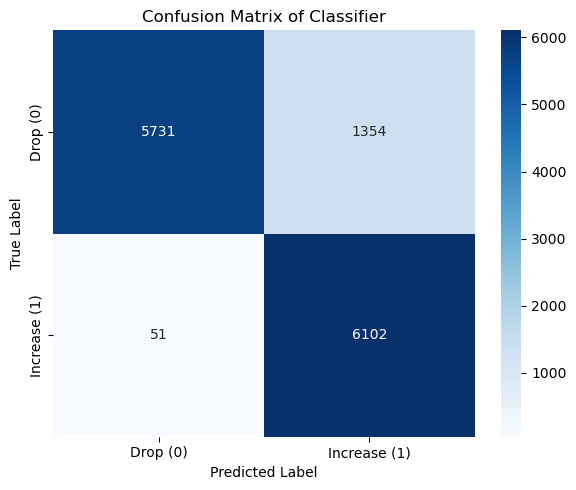

In [16]:
# 1. Create classification labels
y_train_class = (y_train >= 0).astype(int)  # 1 if Increase, 0 if Drop
y_test_class = (y_test >= 0).astype(int)

print("Training labels distribution:")
print(y_train_class.value_counts())
print("Testing labels distribution:")
print(y_test_class.value_counts())

# 2. Train a XGBoost Classifier
clf = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

clf.fit(X_train_wf_processed, y_train_class)

# 3. Predict
y_pred_class = clf.predict(X_test_wf_processed)

# 4. Evaluate
print("\n=== Classification Report ===")
print(classification_report(y_test_class, y_pred_class))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test_class, y_pred_class))

# 1. Create classification labels
y_train_class = (y_train >= 0).astype(int)  # 1 if Increase, 0 if Drop
y_test_class = (y_test >= 0).astype(int)

print("Training labels distribution:")
print(y_train_class.value_counts())
print("Testing labels distribution:")
print(y_test_class.value_counts())

# 2. Train a XGBoost Classifier
clf = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

clf.fit(X_train_wf_processed, y_train_class)

# 3. Predict
y_pred_class = clf.predict(X_test_wf_processed)

# 4. Evaluate
print("\n=== Classification Report ===")
print(classification_report(y_test_class, y_pred_class))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test_class, y_pred_class))

# Compute confusion matrix
cm = confusion_matrix(y_test_class, y_pred_class)
labels = ['Drop (0)', 'Increase (1)']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Classifier')
plt.tight_layout()
plt.show()


The classification model achieved an overall accuracy of 89%, with a recall of 81% for price drops and 99% for price increases. This performance indicates that the model correctly identifies most drop cases while minimizing false positives, providing a reliable foundation for routing observations to specialized regression models in the subsequent prediction stage.


## Stage 2: Conditional Regression
Based on the predicted class:

（1）For increases, we use the baseline model, which already performs well.

（2）For drops, we train a dedicated regression model optimized for this subgroup to better capture the variation and risk factors underlying price declines.


In [14]:
# Predict for Drop cases
# Select training samples where y_train <= 0
drop_train_idx = (y_train <= 0)

X_train_drop = X_train_wf_processed[drop_train_idx]
y_train_drop = y_train[drop_train_idx]

X_train_drop = X_train_wf_processed[drop_train_idx]
y_train_drop = y_train[drop_train_idx]

drop_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.1,
    max_depth=8,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=-1
)
drop_model.fit(X_train_drop, y_train_drop)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [15]:
# Predict classes (0 = Drop, 1 = Increase)
y_test_class_pred = clf.predict(X_test_wf_processed)

# Placeholder for final predictions
y_test_pred_final = np.zeros_like(y_test)

# Predict for Increase cases
# baseline regression model:loaded_model_ubj
increase_idx = (y_test_class_pred == 1)
y_test_pred_final[increase_idx] = loaded_model_ubj.predict(X_test_wf_processed[increase_idx])

drop_idx = (y_test_class_pred == 0)
y_test_pred_final[drop_idx] = drop_model.predict(X_test_wf_processed[drop_idx])

# === Overall performance ===
rmse_overall = np.sqrt(mean_squared_error(y_test, y_test_pred_final))
r2_overall = r2_score(y_test, y_test_pred_final)

print(f"Overall RMSE: {rmse_overall:.4f}")
print(f"Overall R²: {r2_overall:.4f}")

# === Separate performance ===
rmse_drop = np.sqrt(mean_squared_error(y_test[drop_idx], y_test_pred_final[drop_idx]))
r2_drop = r2_score(y_test[drop_idx], y_test_pred_final[drop_idx])

rmse_increase = np.sqrt(mean_squared_error(y_test[increase_idx], y_test_pred_final[increase_idx]))
r2_increase = r2_score(y_test[increase_idx], y_test_pred_final[increase_idx])

print(f"Drop RMSE: {rmse_drop:.4f}, Drop R²: {r2_drop:.4f}")
print(f"Increase RMSE: {rmse_increase:.4f}, Increase R²: {r2_increase:.4f}")


Overall RMSE: 3.2143
Overall R²: 0.9014
Drop RMSE: 3.0457, Drop R²: 0.6333
Increase RMSE: 3.3393, Increase R²: 0.8470


| Metric Category | RMSE    | R²     |
|-----------------|---------|--------|
| **Overall**     | 3.2143  | 0.9014 |
| **Drop** (y $<$ 0)| 3.0457  | 0.6333 |
| **Increase** (y $\geq$ 0) | 3.3393 | 0.8470 |

After implementing a two-stage modeling pipeline and applying RandomizedSearchCV to optimize the drop-specific regressor, we observed clear improvements in model performance.
Specifically, the R² for price drop cases increased from 0.6075 to 0.6333, and the overall R² improved from 0.8961 to 0.9014.
This demonstrates that conditional modeling based on initial classification can effectively capture different market dynamics and improve predictive accuracy, particularly in high-risk cases associated with price declines.  



We successfully demonstrate that applying a two-stage modeling pipeline, consisting of a classification step followed by conditional regression models, leads to improved predictive performance across both drop and increase cases. Further optimizations such as refining the drop-specific training data could be considered in future work, but are beyond the scope of the current project.  

# Part 3: Single Enhanced Model

While our current implementation adopts a two-model approach for improved precision in predicting price declines, future work could explore integrating the classification output or fire exposure indicators directly into the baseline regression model as features. This would allow the model to internally adjust its behavior across different regimes, potentially achieving similar performance without requiring conditional routing logic.

